This notebook reproduces some results of the paper:   

@article{hansen2021frontiers,  
  title={**Frontiers: Algorithmic collusion: Supra-competitive prices via independent algorithms**},  
  author={Hansen, Karsten T and Misra, Kanishka and Pai, Mallesh M},  
  journal={**Marketing Science**},  
  volume={40},  
  number={1},  
  pages={1--12},  
  year={2021},  
  publisher={INFORMS}  
}

**TL, DR**:

This paper analysis the outcomes when two competing sllers (duopoly markets) use UCB algorithm to price homogeneious product dynamically. 

The profit function for each firm is stochastic: $\pi_i(p_i, p_{-i}, \delta)$, where $\delta$ is clled the signal-to-noise ration (**SNR**). A higher $\delta$ indicates lower stochasticity in profit.

The system dynamics yield two possible outcomes:

1. Convergence to Nash equilibrum;

2. Convergence to a **supra-competitive** scenario resembling monopoly pricing.

The learning algorithm is misspecified,  as the UCB algorithm neglects consideration of the competitor's decision.

However, the numerical experiments reveal that the outcome depends on the SNR:

1. when SNR is low: it's more likely to converge to the Nash-equilibrum;

2. when SNR is high: it's more likely to converge to the supra-competitive scenario.

The core of this paper consists of numerical expirements, complemented by straightforward but not rigorous mathematical proofs in the appendix.

In [1]:
import numpy as np
np.random.seed(93)
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Part 1: The Model Setting


Assume there are 2 firms (denoted by $i, j$) selling a homogeneous product within an infinte time period. At each period $t$, firm $i$ gives price $p_{i,t}$ from a discrete space $P=\{p_1, p_2, \cdots, p_K\}$. After facing the price $p_{-i,t}$ by the competitor, the profit can be obtained through a parametric data-generating process (DGP):

$$
\pi_{i,t} = (\alpha - \beta p_{i,t} + \gamma p_{-i, t})\cdot p_{i,t} + \epsilon_t, \\
\epsilon_t \sim U[-\frac1\delta,\frac1\delta],
$$
where $\delta$ is called the signal-to-noise ratio (**SNR**).

From the DGP we can observe:

1. The marginal cost of the product is zero;
2. The demand function is deterministic, the random term is added to the profit only;
3. The SNR is inversely proportional to the stability of the profit;
4. The demand function is <font color="red">symmetric</font> for both firms.

Under such settings, we can calculate the prices under Nash equilibrium (the competitive case) or under collusive pricing (the supra-competitive case) analytically:

$$
Competitive: p^D = \frac{\alpha}{2\beta-\gamma} \\
Collusive: p^M = \frac{\alpha}{2(\beta-\gamma)}
$$

In [1]:
class Hansen_env():

    def __init__(self, info):
        """
        The input parameters info should be dictionary.
        info should contain keys: 'alpha', 'beta', 'gamma', 'delta'
        """
        self.info = info
        self.rewards_log = deque(maxlen=1000)
        self.actions_log = deque(maxlen=1000)
        self.prices_log = deque(maxlen=1000)
        self.action_spaces = None
        self.nash = None
        self.collusion = None
        self.check()
        self.initialize()
    
    def check(self):
        keys = ['alpha', 'beta', 'gamma', 'delta']
        if not all(key in self.info for key in keys):
            raise ValueError("Incorrect Parameters")
        
    def step(self, actions):
        self.actions_log.append(actions)
        prices = self.action_spaces[0][actions[0]], self.action_spaces[1][actions[1]]
        self.prices_log.append(prices)
        rewards = self.execute(prices)
        self.rewards_log.append(rewards)
        return rewards
    
    def execute(self, prices):
        profit1 = (prices[0] * (self.info['alpha']-self.info['beta']*prices[0]+self.info['gamma']*prices[1])) + np.random.uniform(-1/self.info['delta'], 1/self.info['delta'])
        profit2 = (prices[1] * (self.info['alpha']-self.info['beta']*prices[1]+self.info['gamma']*prices[0])) + np.random.uniform(-1/self.info['delta'], 1/self.info['delta'])
        return np.maximum(0, (profit1, profit2))
    
    def initialize(self):
        """
        Compute the nash, collusion prices and the actions spaces.
        """
        nash = self.info['alpha'] / (2*self.info['beta']-self.info['gamma']) 
        self.nash = np.array([nash, nash])
        collusion = 0.5 * self.info['alpha'] / (self.info['beta']-self.info['gamma']) 
        self.collusion = np.array([collusion, collusion])
        self.action_spaces = [np.array([nash, collusion]), np.array([nash, collusion])]

In the baseline model, the action space for each agent is $2$, meaning each agent can only pick price from the $p^D$ and $p^M$. 

The agent utilizes $UCB-tuned$ algorithm to make decision at time $t$:

\begin{aligned}
V_{k,t}& =\overline{\pi_{k,t}^{2}}-\bar{\pi}_{k,t}^{2}+\sqrt{\frac{2\log t}{n_{k,t}}},  \\
\mathrm{UCB-tuned}_{k,t}& =\bar{\pi}_{k,t}+\sqrt{\frac{\log t}{n_{k,t}}\mathrm{min}\left(\frac14,\mathrm{V}_{k,t}\right),} 
\end{aligned}

where $n_{k, t}$ represents the frequency of the agent taking action \(k\) up to time \(t\).To give an intuitive understanding on the formula:

1. The term $\overline{\pi_{k,t}^{2}}-\bar{\pi}_{k,t}^{2}$ is the empirical variance.

2. The term $\sqrt{\frac{\log t}{n_{k,t}}\mathrm{min}(\frac14,\mathrm{V}_{k,t})}$ is used for exploration.

The agent pick action $k$ at time $t$ with the highest index $\mathrm{UCB-tuned}_{k,t}$.


In [3]:
class Hansen_agent:
    def __init__(self):
        self.t = 1
        self.n = np.array([0, 0])
        self.last_action = None
        self.mean = np.zeros(2)
        self.mean2 = np.zeros(2)
        self.V = np.empty(2)
        self.UCB = np.empty(2)

    def action(self):
        action = np.argmax(self.UCB)
        self.last_action = action
        return action

    def update(self, reward):
        self.t += 1
        self.n[self.last_action] += 1
        self.mean[self.last_action] += (reward - self.mean[self.last_action]) / (self.n[self.last_action] + 1)  
        self.mean2[self.last_action] += (reward**2 - self.mean2[self.last_action]) / (self.n[self.last_action] + 1) 
        self.V = self.mean2 - self.mean**2 + np.sqrt(2*np.log(self.t)/self.n)
        self.UCB = self.mean + np.sqrt((np.log(self.t)/self.n)*np.minimum(0.25, self.V))

Because the agents have no information on the bandit at the beginning of the game, they explore randomly at the first two rounds:

1. In the first round, each agent randomly selects one action.
2. In the second round, each agent chooses the opposite action to that of the first round (there are 2 actins in total).
3. Subsequently, each agent makes decisions using the UCB-tuned algorithm.

In [4]:
def initialize(env, agent1, agent2):
    action1 = np.random.choice(np.array(2), 2)
    agent1.last_action, agent2.last_action = action1
    rewards = env.step((agent1.last_action, agent2.last_action))
    agent1.update(rewards[0])
    agent2.update(rewards[1])
    agent1.last_action, agent2.last_action = 1 - action1
    rewards = env.step((agent1.last_action, agent2.last_action))
    agent1.update(rewards[0]) 
    agent2.update(rewards[1])

Now, we can use the parameters set in the paper to construct an environment for interaction.

In [5]:
info = {'alpha': 0.48, 'beta': 0.9, 'gamma': 0.6, 'delta': 5}
env = Hansen_env(info)
agent1, agent2 = Hansen_agent(), Hansen_agent()
initialize(env, agent1, agent2)

In the research, the authors conducted each simulation over a course of 2 million epochs. To analyze the results, they focused on the median prices recorded during the final 1000 rounds. The code below allows for the replication of a single experiment.

In [6]:
for _ in tqdm(range(2000000-2)):
    actions = (agent1.action(), agent2.action())
    rewards = env.step(actions)
    agent1.update(rewards[0])
    agent2.update(rewards[1])
price1 = np.median(np.array(env.prices_log)[:, 0])
price2 = np.median(np.array(env.prices_log)[:, 1])
print(f"The median prices of the last 1000 rounds after 2 million epochs are {price1} and {price2} respectively.")

100%|██████████| 1999998/1999998 [00:38<00:00, 51568.62it/s]

The median prices of the last 1000 rounds after 2 million epochs are 0.7999999999999998 and 0.7999999999999998 respectively.


# Part 2: The Main Resuts

In the paper, the authors dicuss the impact of *SNR* on the pricing outcome. 

For each given SNR, 500 Monte Carlo Simulations are performed. For each simulation, the **median price** charged in the last 1,000 rounds out of two million rounds is considered.

<div style="text-align:center;">
    <img src="pic/Hansen_pic2.png" alt="Alt text" style="display:inline-block;width:300px; height:300px;">
</div>

The contour graph you see above is actually Figure 2 from the paper, which shows the median prices observed after a lengthy number of epochs. The main goal of this notebook is to recreate that figure. The simulation process is time-intensive, and the code below leverages `multiprocessing` to speed up the experimentation. Please note that this code isn't designed to run directly within the notebook environment. If the readers are interested in running it, the `hansen2021frontiers.py` script can function well. Once executed, the results will be saved in a `json` file.

```python
def simulate(delta):
    info = {'alpha': 0.48, 'beta': 0.9, 'gamma': 0.6, 'delta': delta}
    env = Hansen_env(info)
    agent1, agent2 = Hansen_agent(), Hansen_agent()
    initialize(env, agent1, agent2)
    for _ in range(2000000-2):
        actions = (agent1.action(), agent2.action())
        rewards = env.step(actions)
        agent1.update(rewards[0])
        agent2.update(rewards[1])
    price1 = np.median(np.array(env.prices_log)[:, 0])
    price2 = np.median(np.array(env.prices_log)[:, 1])
    return price1, price2

delta_list = [0.1, 0.2, 0.4, 1, 2.5, 5, 10]
results = {delta:[] for delta in delta_list}
for delta in delta_list:
    t0 = time.time()
    print(f"Now simulating params delta: {delta}.")
    params = [(delta,) for _ in range(10)]
    with Pool(processes=15) as pool:
        result = pool.starmap(simulate, params)
    t1 = time.time() - t0
    print(f"The calculation takes {t1} seconds.")
    results[delta] = result
with open('data/hansen2021frontiers_results.json', 'w') as json_file:
    json.dump(results, json_file)
```

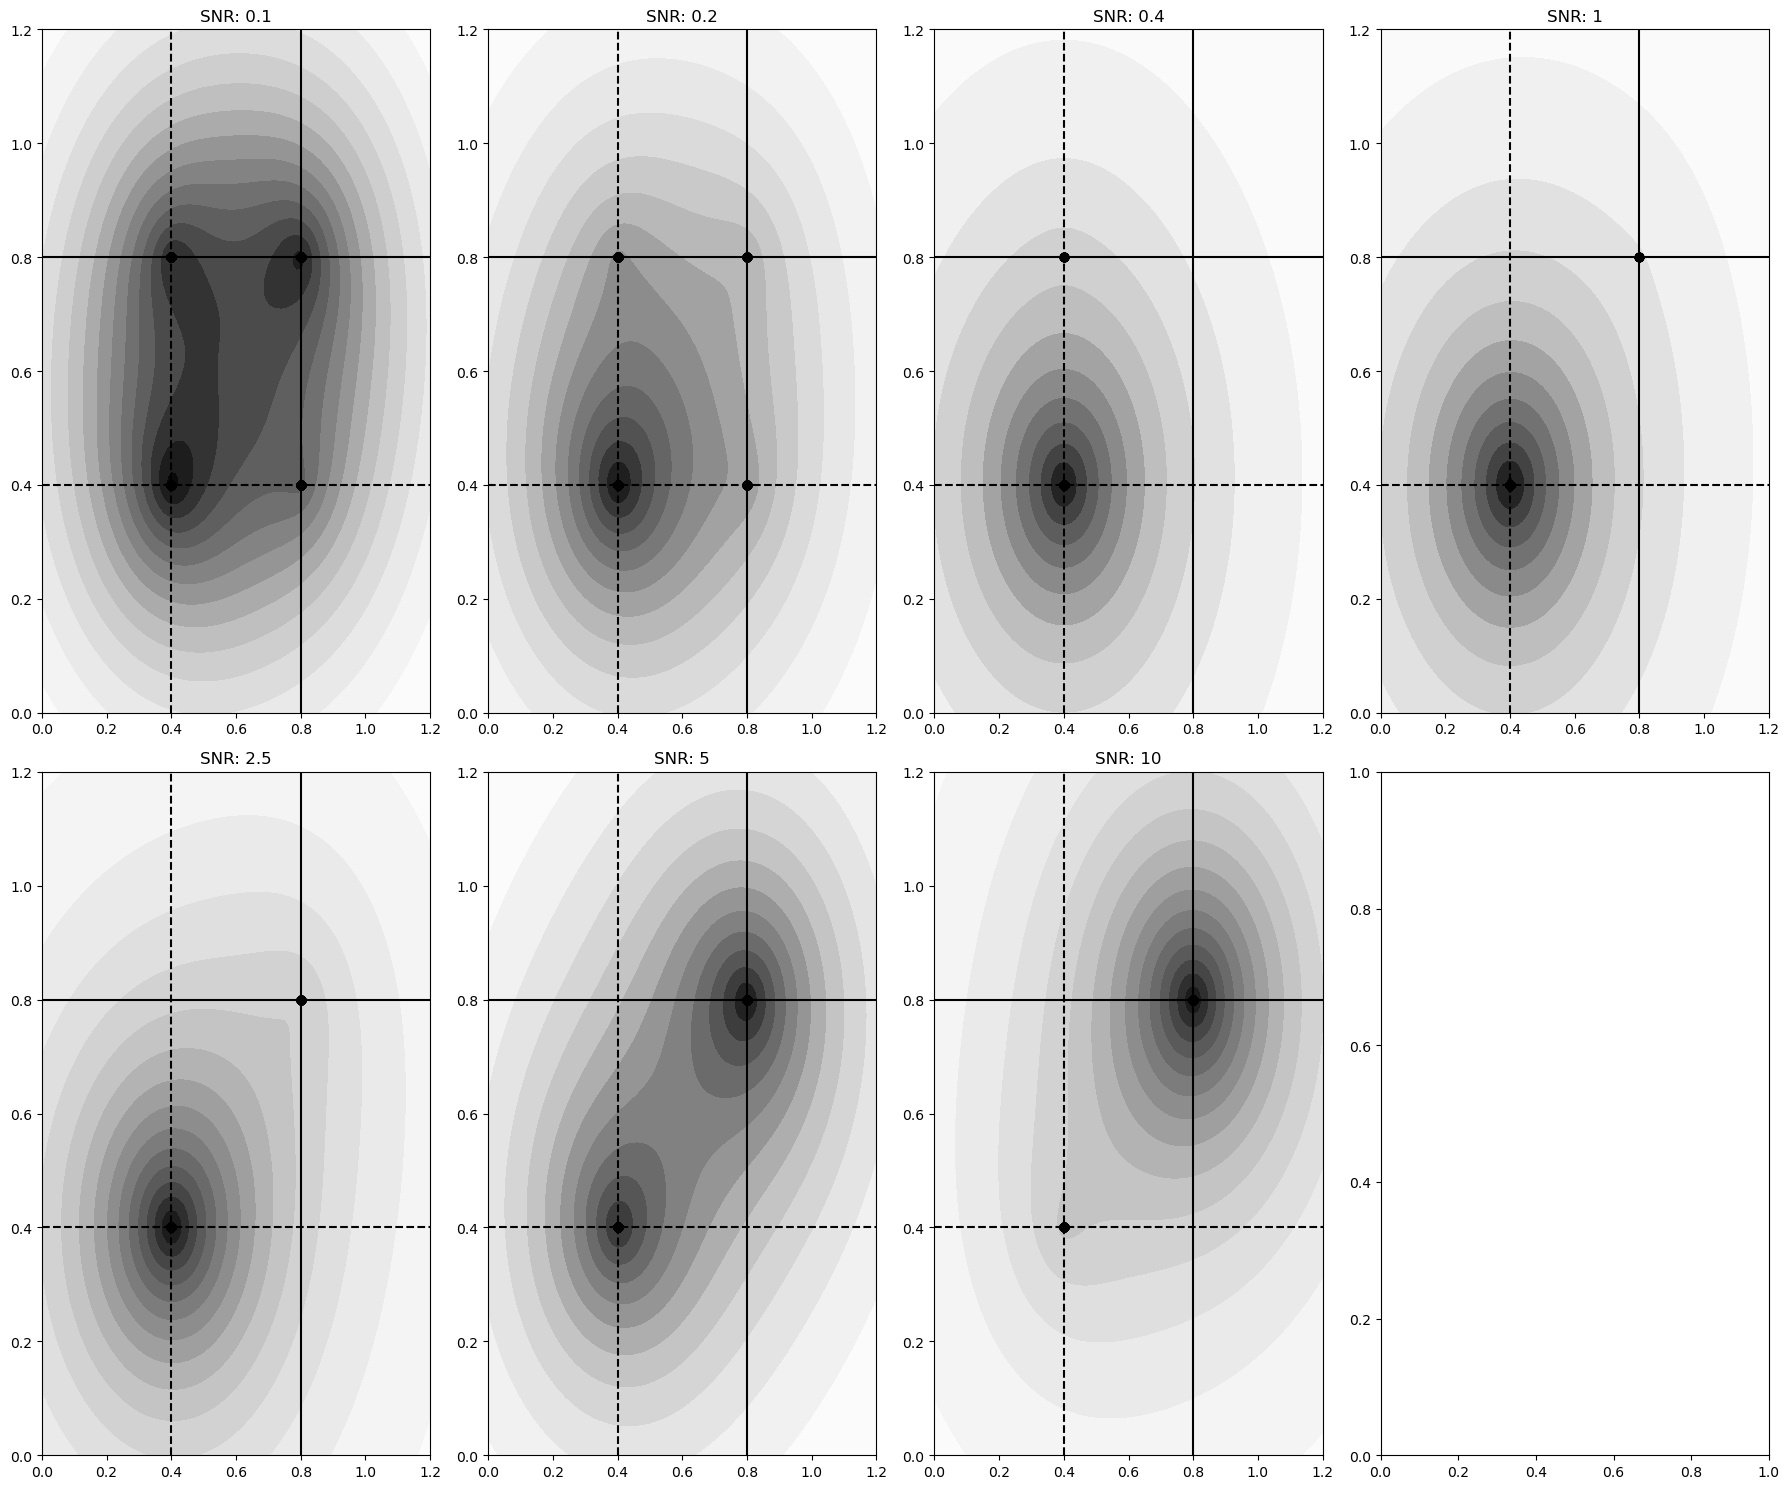

In [7]:
with open('data/hansen2021frontiers_results.json', 'r') as file:
    results = json.load(file)

def plot_density_contour(ax, results, key):
    data = np.array(results[key])
    kde = KernelDensity(kernel='exponential', bandwidth=0.3).fit(data)
    x = np.linspace(0, 1.2, 100)
    y = np.linspace(0, 1.2, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()]).T
    densities = np.exp(kde.score_samples(positions))
    density = densities.reshape(X.shape)
    ax.contourf(X, Y, density, 14, cmap='Greys')
    ax.scatter(data[:, 0], data[:, 1], marker='o', color='k')
    ax.axvline(x=0.4, color='black', linestyle='--')
    ax.axvline(x=0.8, color='black', linestyle='solid')
    ax.axhline(y=0.4, color='black', linestyle='--')
    ax.axhline(y=0.8, color='black', linestyle='solid')
    ax.set_title(f'SNR: {key}')

fig, axs = plt.subplots(2, 4, figsize=(18, 15))
keys = ['0.1', '0.2', '0.4', '1', '2.5', '5', '10']
for i, key in enumerate(keys):
    row = i // 4
    col = i % 4
    plot_density_contour(axs[row, col], results, key)

plt.tight_layout()
plt.show()

In this paper, the authors present straightforward proofs to elucidate the scenario where both firms charge monopoly prices. Although the theoretical assumptions do not perfectly correspond with the outcomes of the numerical simulations (it is assumed that the demand function is deterministic: $\delta\to\infty$), they offer a clear intuitive understanding.

The theory can imporove our understanding on that as the Signal-to-Noise Ratio (SNR) increases—indicating a more predictable reward—the likelihood of the market converging towards a supra-competitive scenario also rises.